# Impor Libraries

In [1]:
# Reload modulos automaticamente
%load_ext autoreload
%autoreload 2
from modules.gnn import GNN
from modules.models import GraphSAGE, GCN,ModelSAGESample
from modules.predictors import DotPredictor, MLPPredictor
from modules.graph_from_api import Graph_API

import torch.nn.functional as F
from torch.optim import Adam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
from utils import *
from modules.graph import Graph
import numpy as np
import os
import fnmatch
import tqdm



In [2]:
print("Versión de DGL:", dgl.__version__)
print("Versión de PyTorch:", torch.__version__)

Versión de DGL: 2.4.0
Versión de PyTorch: 2.3.0+cu121


In [3]:
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}

# Caso 1: 
    * Model :GraphSAGE
    * Features : Todos 
    * Predictor : DotProduct
    

In [9]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
# Path de donde se guardaran archivos
path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "/home/vale/Desktop/GIT/TESIS/datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename)

# 3.- Eliminar nodos de grado 1 hojas

# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges


Done saving data into cached files.
Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Training edges: 184613
Validation edges: 138684
Test edges: 138592
In epoch 0, train loss: 2.4013633728027344, val loss: 2.3999485969543457
In epoch 10, train loss: 0.7201789021492004, val loss: 0.7191571593284607
In epoch 20, train loss: 0.6899123787879944, val loss: 0.6893333196640015
In epoch 30, train loss: 0.6712314486503601, val loss: 0.6709299683570862
In epoch 40, train loss: 0.6601377129554749, val loss: 0.660338282585144
In epoch 50, train loss: 0.6493674516677856, val loss: 0.6501780152320862
In epoch 60, train loss: 0.6409755349159241, val loss: 0.6424144506454468
In epoch 70, train loss: 0.6347228288650513, val loss: 0.636518120765686
In epoch 80, train loss: 0.6291463971138, val loss: 0.6309778690338135
In epoch 90, train loss: 0.6226334571838379, val l

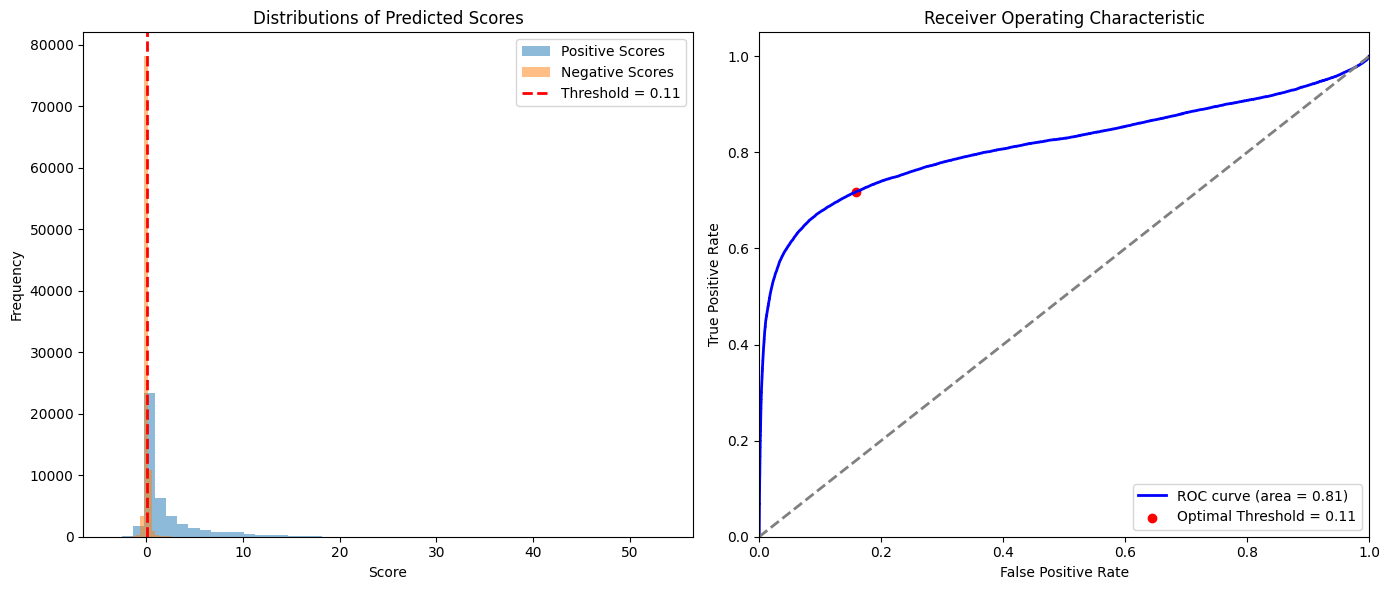

AUC: 0.8149841327184305


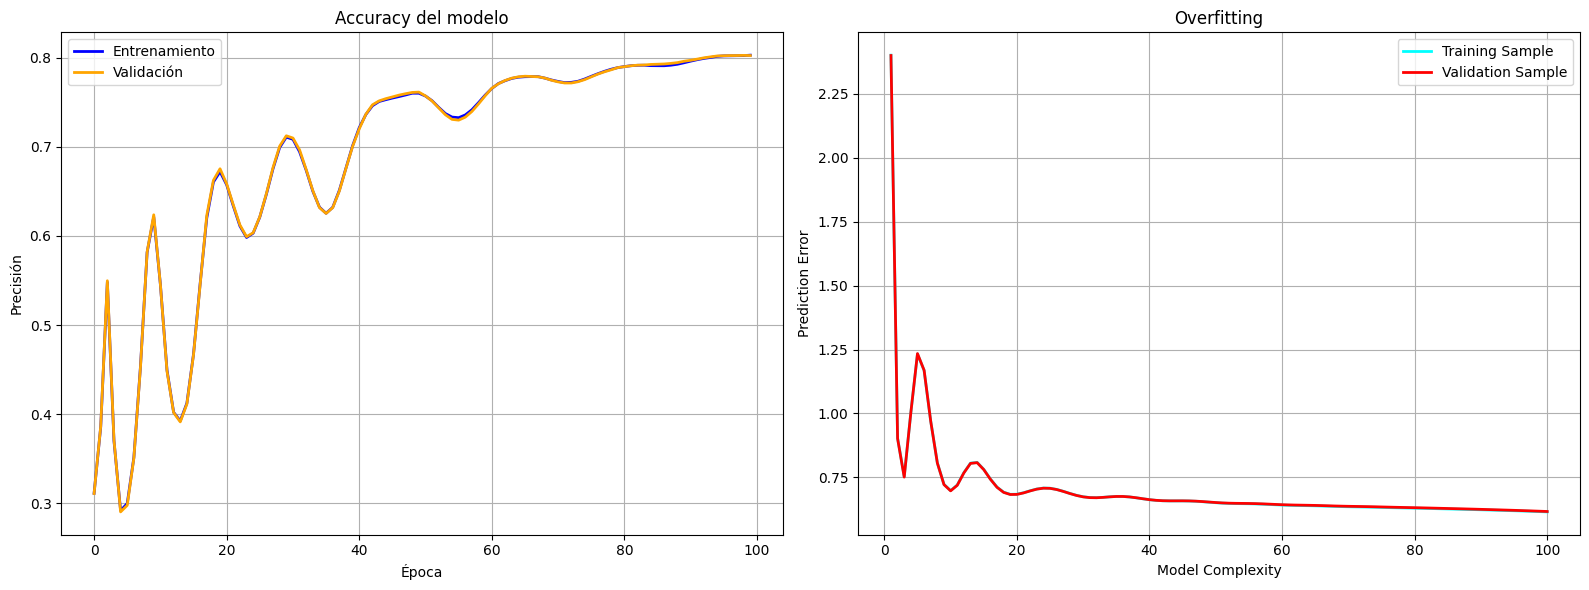

In [12]:
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset(0.4)
# gnn.split_dtaset_v2()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1
labels = gnn.dgl_graph.edata["Relationship"].float()
num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 15
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, num_feat_out)
pred = DotPredictor()

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.007)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())
  
  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())


  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)




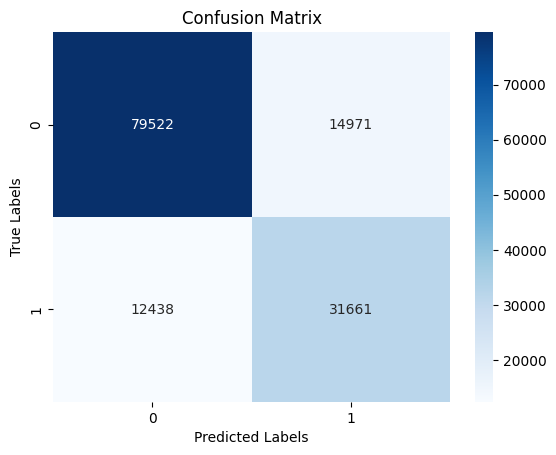

Classification Report:

              precision    recall  f1-score   support

           0     0.8647    0.8416    0.8530     94493
           1     0.6790    0.7180    0.6979     44099

    accuracy                         0.8022    138592
   macro avg     0.7718    0.7798    0.7755    138592
weighted avg     0.8056    0.8022    0.8036    138592



In [13]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

# Caso 2: 
    * Model :GraphSAGE
    * Features : ALL
    * Predictor : MLPPredictor
    

In [14]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
# Path de donde se guardaran archivos
path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "/home/vale/Desktop/GIT/TESIS/datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename)

# 3.- Eliminar nodos de grado 1 hojas

# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges


Done saving data into cached files.
Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
Training edges: 277085
Validation edges: 92274
Test edges: 92530
In epoch 0, train loss: 0.6814088821411133, val loss: 0.6813556551933289
In epoch 10, train loss: 0.5624640583992004, val loss: 0.5620725154876709
In epoch 20, train loss: 0.4477986693382263, val loss: 0.44698938727378845
In epoch 30, train loss: 0.3188222050666809, val loss: 0.3178567588329315
In epoch 40, train loss: 0.23192842304706573, val loss: 0.2315196692943573
In epoch 50, train loss: 0.18097302317619324, val loss: 0.18033260107040405
In epoch 60, train loss: 0.15803460776805878, val loss: 0.15751461684703827
In epoch 70, train loss: 0.14624391496181488, val loss: 0.14611320197582245
In epoch 80, train loss: 0.1390766203403473, val loss: 0.13866117596626282
In epoch 90, train loss: 0.13357706367

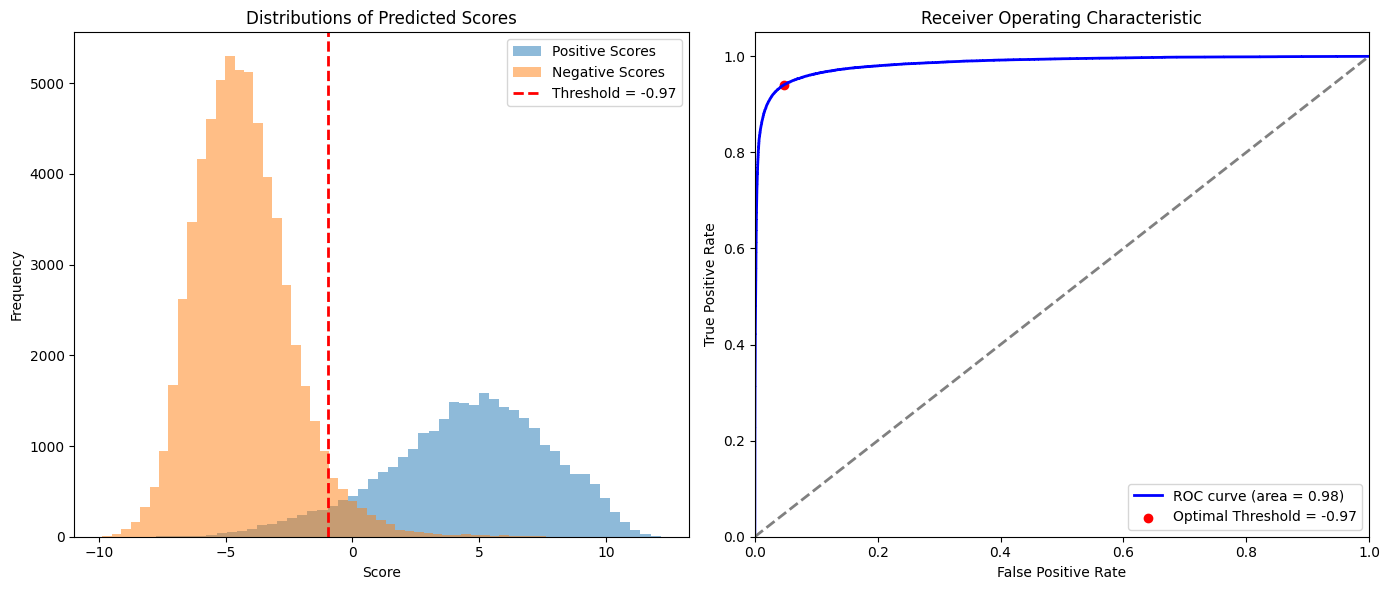

AUC: 0.984781806332338


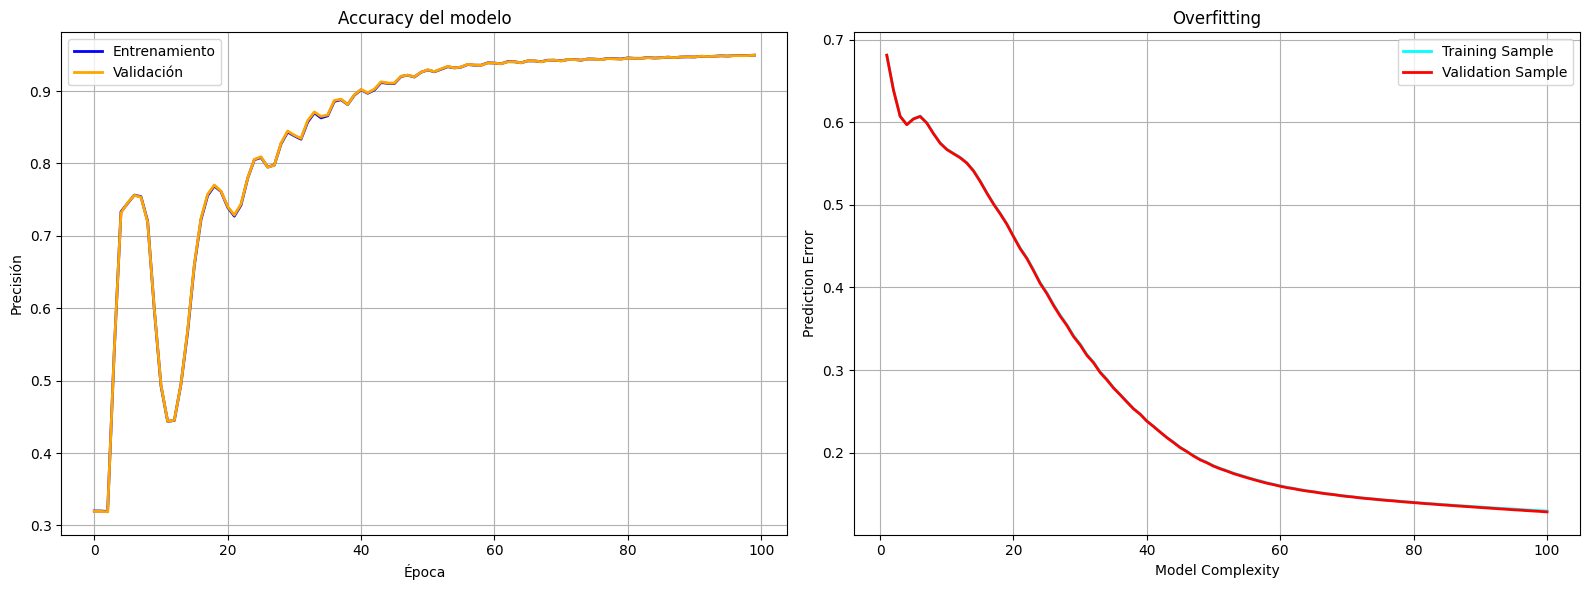

In [31]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.006)

# ----------- 4. training -------------------------------- #
# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []
for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())


  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())

  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  

  # backward
  optimizer.zero_grad()
  # train_loss.backward()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)


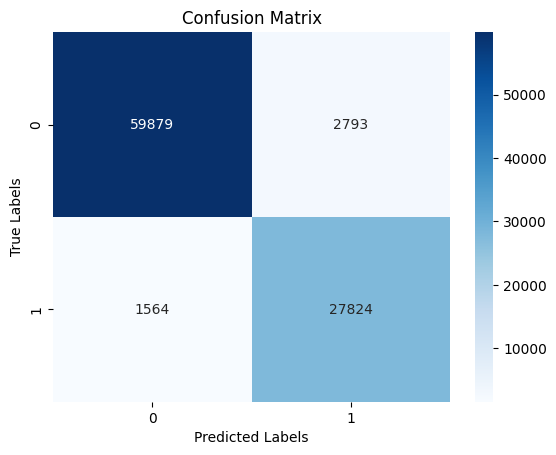

Classification Report:

              precision    recall  f1-score   support

           0     0.9745    0.9554    0.9649     62672
           1     0.9088    0.9468    0.9274     29388

    accuracy                         0.9527     92060
   macro avg     0.9417    0.9511    0.9461     92060
weighted avg     0.9536    0.9527    0.9529     92060



In [26]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

# Caso 3: 
    * Model :GraphSAGE
    * Features : in_degree y out_degree
    * Predictor : DotPredictor
    

In [16]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
""" node_id,feat
 1,"10, 7"
 7843,"33, 54"

 """

path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraphDegree/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.only_degree_features_nodes(features_filename)


graph.add_as_rank_api_attributes()
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges
[SAVE IN: /home/vale/Desktop/GIT/TESIS/datasets/DGL_Graph/MYCODEDiGraphDegree/nodes.csv]


AttributeError: 'Graph' object has no attribute 'add_as_rank_api_attributes'

Done saving data into cached files.
[DATASET] Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
[DATASET] tensor([[0.2626, 0.2277],
        [0.3036, 0.1518],
        [0.3385, 0.1203],
        ...,
        [0.1203, 0.0000],
        [0.1203, 0.2809],
        [0.0759, 0.0000]])
In epoch 0, train loss: 0.7340303063392639, val loss: 0.7337589859962463
In epoch 10, train loss: 0.5595546960830688, val loss: 0.5610631108283997
In epoch 20, train loss: 0.41880759596824646, val loss: 0.4192700982093811
In epoch 30, train loss: 0.23924949765205383, val loss: 0.23960182070732117
In epoch 40, train loss: 0.2037019580602646, val loss: 0.20426668226718903
In epoch 50, train loss: 0.19553019106388092, val loss: 0.1965281069278717
In epoch 60, train loss: 0.18720172345638275, val loss: 0.1880284696817398
In epoch 70, train loss: 0.18062397837638855, val loss: 0.1814766

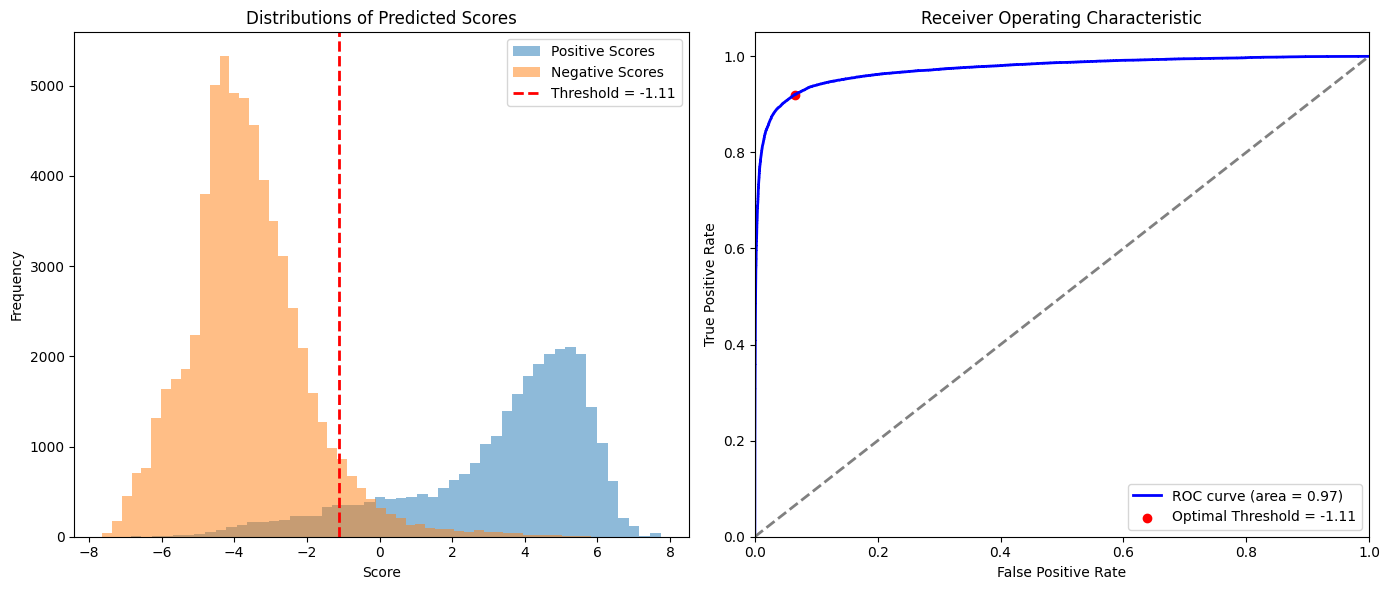

AUC: 0.9736283043563153


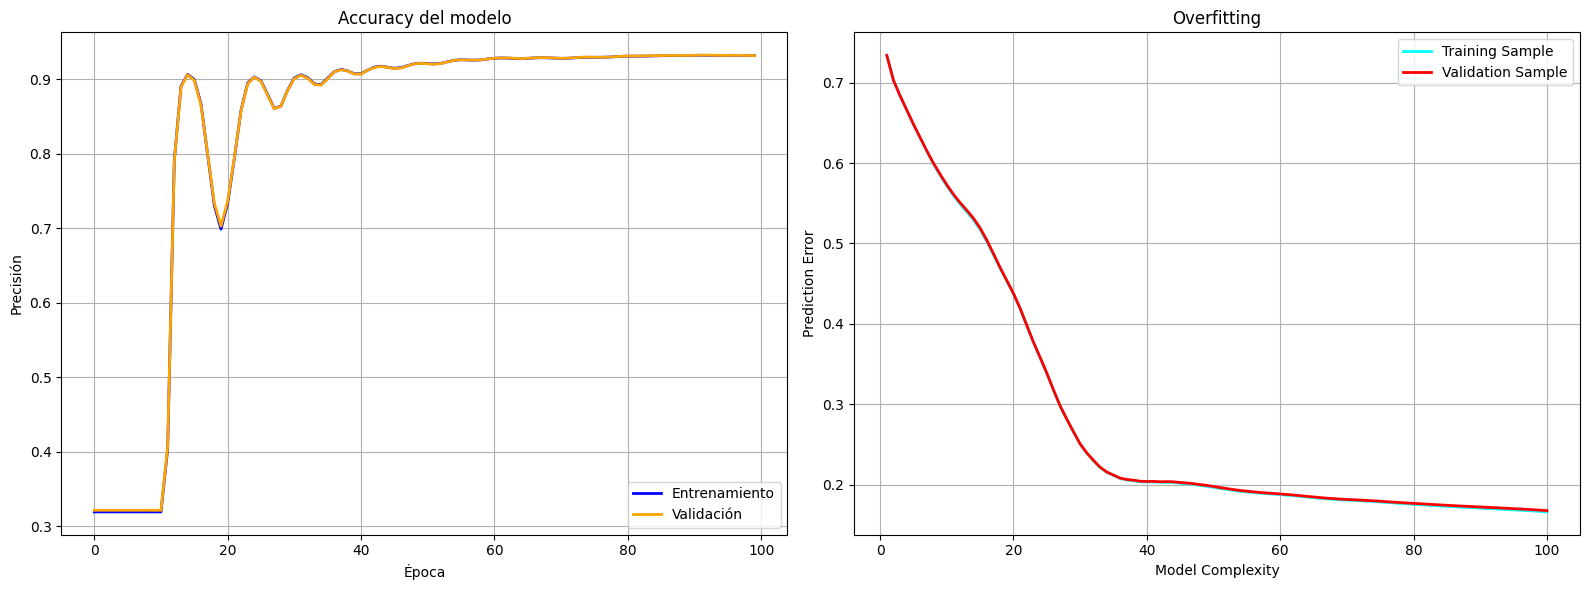

In [82]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraphDegree/"

gnn = GNN(debug=False)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset(0.6)

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:
# print(gnn.dgl_graph.ndata['feat'] )

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 15
num_feat_out = 1
# DATASET GRAPH ----------------------------------------------
print("[DATASET]",gnn.dgl_graph)
print("[DATASET]",gnn.dgl_graph.ndata['feat'])

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())


  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())

  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #
plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)


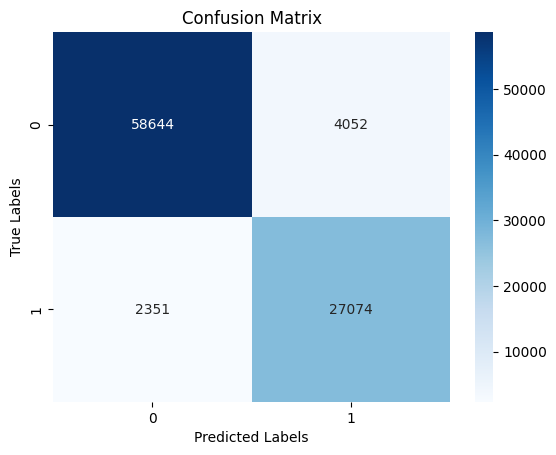

Classification Report:

              precision    recall  f1-score   support

           0     0.9615    0.9354    0.9482     62696
           1     0.8698    0.9201    0.8943     29425

    accuracy                         0.9305     92121
   macro avg     0.9156    0.9277    0.9212     92121
weighted avg     0.9322    0.9305    0.9310     92121



In [83]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

# Caso 4: 
    * Model :GraphSAGE
    * Features : ['AS_rank_continent','peeringDB_info_ratio','peeringDB_info_scope','peeringDB_info_type','peeringDB_policy_general' 'ASDB_C1L1', 'AS_rank_numberAsns', 'AS_rank_customer', 'AS_rank_peer', 'peeringDB_ix_count', 'peeringDB_fac_count', 'cti_top']
    * Predictor : MLPPredictor

In [47]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------

LIST_FEATURES_NO_CATEG = [
                        # 'AS_rank_numberAsns', 
                        # 'AS_rank_customer', 
                        'peeringDB_fac_count', 
                        'cti_top']

LIST_FEATURES_CATEG = [
                        # 'AS_rank_continent',
                        #  'peeringDB_info_ratio',
                        # 'peeringDB_info_scope',
                        # 'peeringDB_info_type',
                        # 'peeringDB_policy_general'
                        # 'ASDB_C1L1'
                        ]

# Crear Di graph 
# list_feat = LIST_FEATURES_NO_CATEG + LIST_FEATURES_CATEG
list_feat =  LIST_FEATURES_NO_CATEG

path_dataset = os.getcwd() +  "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  # o "MultiDiGraph"
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename,list_feat)


# 3.- Eliminar nodos de grado 1 hojas

# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges


Done saving data into cached files.
[IN_FEATS] tensor([[0.0000, 0.0000],
        [0.0000, 0.0192],
        [0.1653, 0.0049],
        ...,
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000]])
[DGL Graph] Graph(num_nodes=74145, num_edges=461889,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int64)})
In epoch 0, train loss: 0.6820039749145508, val loss: 0.6820196509361267
In epoch 10, train loss: 0.644230842590332, val loss: 0.6444259285926819
In epoch 20, train loss: 0.5965187549591064, val loss: 0.596882164478302
In epoch 30, train loss: 0.52840656042099, val loss: 0.5290771126747131
In epoch 40, train loss: 0.44475504755973816, val loss: 0.44576334953308105
In epoch 50, train loss: 0.3790050745010376, val loss: 0.3808739185333252
In epoch 60, train loss: 0.3564373552799225, val loss: 0.35848671197891235
In epoch 70, train loss: 0.3400089740753174, val loss: 0.342186599969

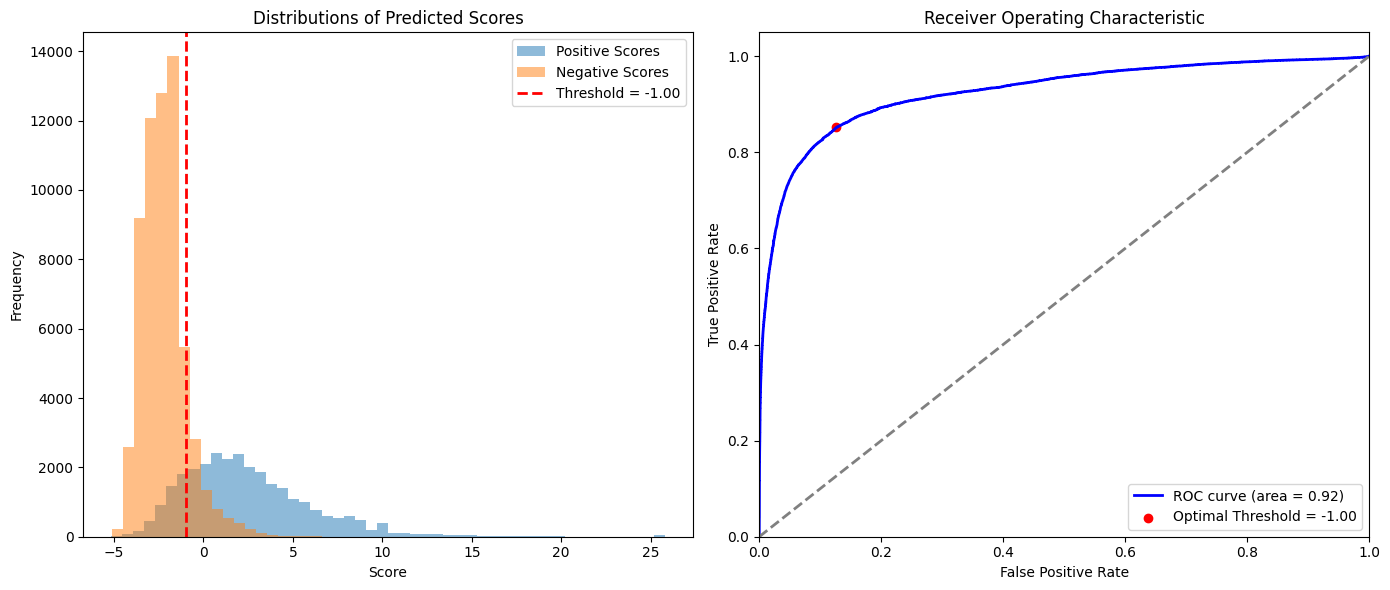

AUC: 0.9248093810245266


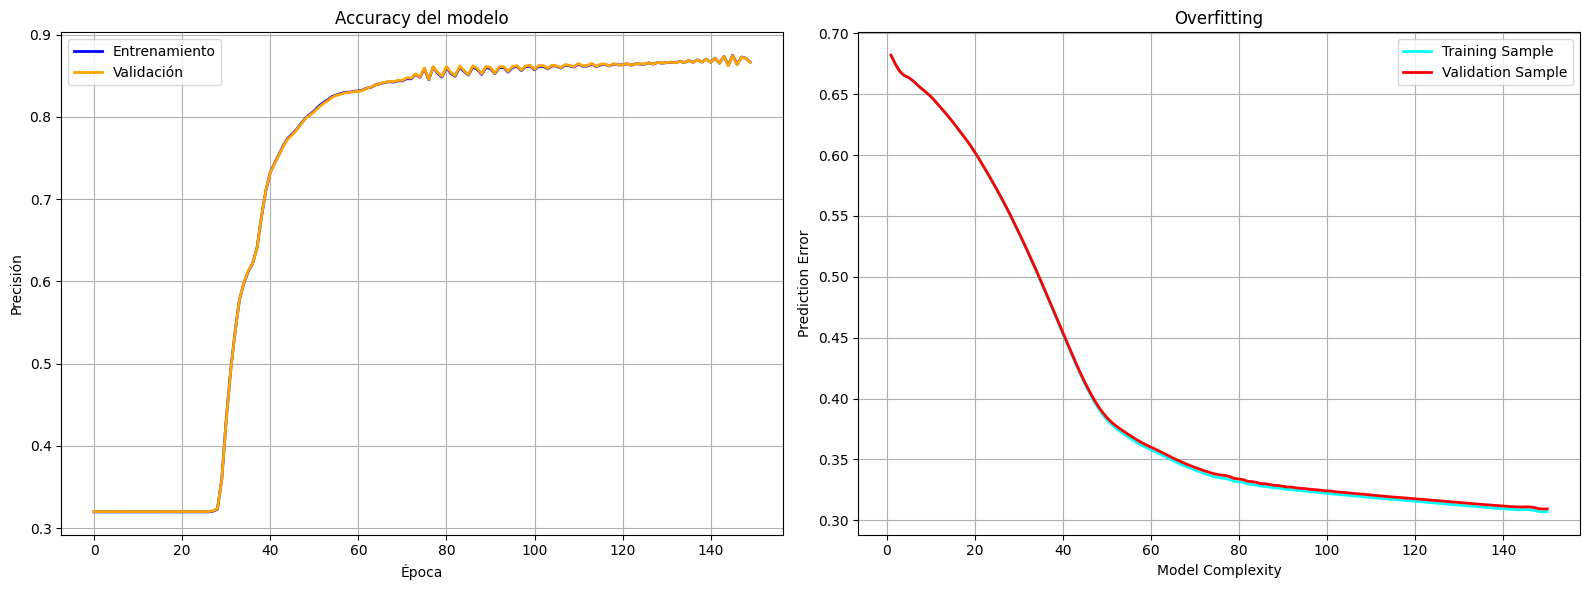

In [48]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=False)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset(0.6)

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"]
print("[IN_FEATS]",in_feats)
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# DATASET GRAPH ----------------------------------------------
print("[DGL Graph]",gnn.dgl_graph)

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in , num_feat_hidden, 8)
pred = MLPPredictor(8,1)


# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.005)

# ----------- 4. training -------------------------------- #
# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(150):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())


  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())

  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)


  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)


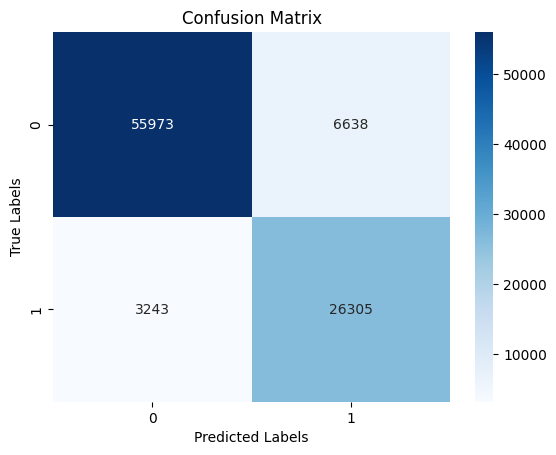

Classification Report:

              precision    recall  f1-score   support

           0     0.9452    0.8940    0.9189     62611
           1     0.7985    0.8902    0.8419     29548

    accuracy                         0.8928     92159
   macro avg     0.8719    0.8921    0.8804     92159
weighted avg     0.8982    0.8928    0.8942     92159



In [36]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)


# Caso 5:
    * Model : ???
    * Features : ???
    * Predictor : ???
Se crea un grafo a partir de un collector de RIPE NCC y ver si este generaliza para otro grafos

In [ ]:
features_filename 

In [8]:
# Creación archivos edges.csv y nodes.csv para cada archivo de rrc y caida ----------------------------
# para la creación de nuestro dataset
path_files_rrc = "datasets/ROUTE_COLLECTORS/Downloads/"
path_files_caida = "datasets/CAIDA_AS_Relationships/Serial_2/"
list_downloaded_rrc_files = os.listdir(path_files_rrc)
list_caida_As_relationship = os.listdir(path_files_caida)
print(list_downloaded_rrc_files)
# list_downloaded_rrc_files = ['graph-2021-06-rrc03-ribs-edges.csv']
# list_downloaded_rrc_files = [ 'graph-2021-06-rrc03-ribs-edges.csv','graph-2022-03-rrc03-ribs-edges.csv','graph-2022-04-rrc01-ribs-edges.csv']

for edgelist_files in list_downloaded_rrc_files:

    # Extraer rrc, fecha y obtener archivo caida p ara año y mes    
    rrc = edgelist_files.split("-")[3]
    date = edgelist_files.split("-")[1] +edgelist_files.split("-")[2]  #202206
    finename_caida_relationships = fnmatch.filter(list_caida_As_relationship, date+"*")
    filename_edges = "edges_"+rrc+".csv"  # Nombre archivo edges (ej_edges_rrc0.csv)
    filename_nodes = "nodes_"+rrc+".csv"  # Nombre archivo nodes (ej_nodes_rrc0.csv)

    edge_list_source_file_csv = path_files_rrc + edgelist_files
    labeled_caida_data_file = path_files_caida + finename_caida_relationships[0] #FIXME: Si pongo un ade la mismma fecha hay valores que no me encuentra (edges para etiquetar)
    # labeled_caida_data_file = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2" #FIXME:Aqui esta el error
    
    # Directorio DGL Graph
    directory = f"datasets/DGL_Graph/Graphs{rrc}/"

    # Crear el directorio si no existe
    if not os.path.exists(directory):
        os.makedirs(directory)

    graph = Graph(f"datasets/DGL_Graph/Graphs{rrc}/", debug=True)
    graph.label_edgelist(labeled_caida_data_file,edge_list_source_file_csv,type="DiGraph",filename_out=filename_edges)
    print("[TOPOLOGÍA]", graph.nx_graph)
    # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
    features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
    # graph.features_nodes(features_filename,list_feat="all",filename_out=filename_nodes)
    graph.only_degree_features_nodes(features_filename,list_feat="all",filename_out=filename_nodes)

    # 3.- Eliminar nodos de grado 1 hojas
    # graph.remove_nodes_degree(1,filename_out=filename_edges)
    # graph.remove_nodes_degree(1,filename_out=filename_edges)
    # graph.remove_nodes_degree(1,filename_out=filename_edges)
    print("-------------------------------")


['graph-2022-01-rrc15-ribs-edges.csv', 'graph-2021-01-rrc23-ribs-edges.csv', 'graph-2021-01-rrc01-ribs-edges.csv', 'graph-2020-01-rrc15-ribs-edges.csv', 'graph-2021-01-rrc15-ribs-edges.csv', 'graph-2022-01-rrc01-ribs-edges.csv', 'graph-2022-01-rrc23-ribs-edges.csv', 'graph-2020-01-rrc01-ribs-edges.csv']
[Tamaño df_edges: (470202, 3)]
[Tamaño df_edges_labeless: (204856, 2)]
Creando archivo edges.csv
[Tamaño Data Frame Merge]: (204856, 3)
[Grafo NX]: DiGraph with 78692 nodes and 204854 edges
[SAVE IN]: datasets/DGL_Graph/Graphsrrc15/edges_rrc15.csv
[TOPOLOGÍA] DiGraph with 78692 nodes and 204854 edges


TypeError: Graph.only_degree_features_nodes() got an unexpected keyword argument 'list_feat'

In [7]:
# Extraer rrc, fecha y obtener archivo caida p ara año y mes   
edgelist_files = 'graph-2022-01-rrc15-ribs-edges.csv'
rrc = edgelist_files.split("-")[3]
date = edgelist_files.split("-")[1] +edgelist_files.split("-")[2]  #202206
finename_caida_relationships = fnmatch.filter(list_caida_As_relationship, date+"*")
filename_edges = "edges_"+rrc+".csv"  # Nombre archivo edges (ej_edges_rrc0.csv)
filename_nodes = "nodes_"+rrc+".csv"  # Nombre archivo nodes (ej_nodes_rrc0.csv)

edge_list_source_file_csv = path_files_rrc + edgelist_files
labeled_caida_data_file = path_files_caida + finename_caida_relationships[0] #FIXME: Si pongo un ade la mismma fecha hay valores que no me encuentra (edges para etiquetar)
labeled_caida_data_file = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"

graph = Graph(f"datasets/DGL_Graph/GraphsRRC{rrc}/", debug=True)
graph.label_edgelist(labeled_caida_data_file,edge_list_source_file_csv,type="DiGraph")
print("[TOPOLOGÍA]", graph.nx_graph)
# 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename,list_feat="all",filename_out=filename_nodes)

# 3.- Eliminar nodos de grado 1 hojas
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

NameError: name 'list_caida_As_relationship' is not defined

In [6]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/Graphsrrc01"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=True)

print(gnn.dgl_graph)

gnn.split_dataset(0.6)

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)


# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.05)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())
  
  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())


  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_train_scores = logits.detach().numpy()[test_mask]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)




Done saving data into cached files.
Graph(num_nodes=67786, num_edges=158967,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.float32)})
Graph(num_nodes=67786, num_edges=158967,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.float32)})
Training edges: 95583
Validation edges: 31899
Test edges: 31485
In epoch 0, train loss: nan, val loss: nan
In epoch 10, train loss: nan, val loss: nan
In epoch 20, train loss: nan, val loss: nan
In epoch 30, train loss: nan, val loss: nan
In epoch 40, train loss: nan, val loss: nan
In epoch 50, train loss: nan, val loss: nan
In epoch 60, train loss: nan, val loss: nan
In epoch 70, train loss: nan, val loss: nan
In epoch 80, train loss: nan, val loss: nan
In epoch 90, train loss: nan, val loss: nan


/home/vale/.local/lib/python3.10/site-packages/sklearn/utils/_array_api.py:390: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.

In [ ]:
# TODO: Importar segundo dataset para el test

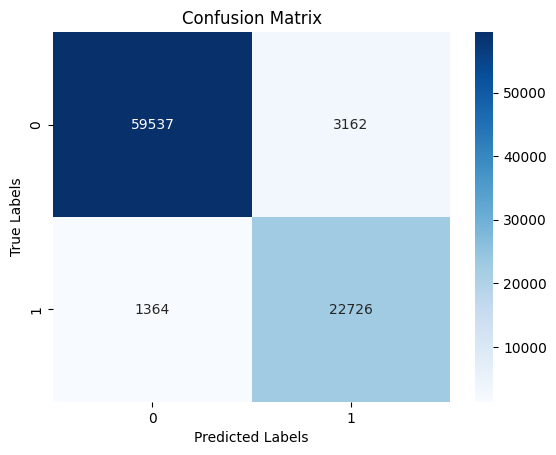

Classification Report:

              precision    recall  f1-score   support

           0     0.9776    0.9496    0.9634     62699
           1     0.8779    0.9434    0.9094     24090

    accuracy                         0.9479     86789
   macro avg     0.9277    0.9465    0.9364     86789
weighted avg     0.9499    0.9479    0.9484     86789



In [55]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

# Caso 6:
    * Model : ???
    * Features : ???
    * Predictor : ???
Agrefo mis atributos sacados de APIs

In [ ]:
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}

In [3]:
date = "2020-01-01"
graph_api = Graph_API(path="datasets/DGL_Graph/Graphsrrc01/", date=date,debug=True)
edge_list_source_file_csv = "datasets/ROUTE_COLLECTORS/Downloads/graph-2020-01-rrc01-ribs-edges.csv"
# 1.- Creo topologia dataset y label 
type = "DiGraph"  # o "MultiDiGraph"
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
# graph_api.label_edgelist(edge_list_source_file_csv, type="DiGraph", filename_out="edges_rrc01.csv") #Se de mora demaiado tiempo

graph_api.read_from_relationship_edgelist(file_path,type,out_file="edges_rrc01.csv")
print("[TOPOLOGÍA]", graph_api.nx_graph)

# asn = "14117"  # Reemplaza este valor con el ASN que desees consultar
result = graph_api.features_nodes(filename_out="nodes_rrc01.csv")
# Filtrar edges con nodos 
graph_api.filter_edges_with_attributes(nodes_file="nodes_rrc01.csv", edges_file="edges_rrc01.csv", output_file="edges_rrc01.csv")

# graph_api.normalize_features("nodes_rrc01.csv","nodes_rrc01.csv")

# print(result)  # Imprimir el JSON retornado

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges
Creating nodes.csv file
[PATH] datasets/DGL_Graph/Graphsrrc01/nodes_rrc01.csv
Node 500 of 74145 processed
Node 1000 of 74145 processed
Node 1500 of 74145 processed
Node 2000 of 74145 processed
Node 2500 of 74145 processed
Node 3000 of 74145 processed
Node 3500 of 74145 processed
Node 4000 of 74145 processed
Node 4500 of 74145 processed
Node 5000 of 74145 processed
Node 5500 of 74145 processed
Node 6000 of 74145 processed
Node 6500 of 74145 processed
Node 7000 of 74145 processed
Node 7500 of 74145 processed
Node 8000 of 74145 processed
Node 8500 of 74145 processed
Node 9000 of 74145 processed
Node 9500 of 74145 processed
Node 10000 of 74145 processed
Node 10500 of 74145 processed
Node 11000 of 74145 processed
Node 11500 of 74145 processed
Node 12000 of 74145 processed
Node 12500 of 74145 processed
Node 13000 of 74145 processed
Node 13500 of 74145 processed
Node 14000 of 74145 processed
Node 14500 of 74145 processed
Node 15000 of 7414

TypeError: 'NoneType' object is not subscriptable

# Caso 7:
    * Model : GraphSAGE 
    * Features : ???
    * Predictor : MLP

SAMPLING-> Neighbour node sampling
BATCH NORMALIZATION ->
DROPOUT ->



In [2]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
# Path de donde se guardaran archivos
path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "/home/vale/Desktop/GIT/TESIS/datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename)

# 3.- Eliminar nodos de grado 1 hojas

# NO PERMITE TENER NODOS CON GRADO 0
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)
# graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges


In [32]:
# Grafo
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"
# data_path = "datasets/DGL_Graph/MYCODEDiGraphDegree/"
gnn = GNN(debug=False)
gnn.load_dataset( data_path, force_reload=True)
gnn.split_dataset(0.5)
gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:
node_features = gnn.dgl_graph.ndata['feat']
labels = gnn.dgl_graph.edata["Relationship"].float()

# gnn.split_dtaset_v2()
train_mask = gnn.train_mask
test_mask = gnn.test_mask

# Obtener índices de nodos de entrenamiento
train_nids = train_mask.nonzero(as_tuple=True)[0]

# Obtener índices de nodos de prueba
test_nids = test_mask.nonzero(as_tuple=True)[0]

print(f"TRAIN IDX: {train_mask}")
print(f"TEST IDX: {test_mask}")

print(f"TRAIN NIDS: {train_nids}")
print(f"TEST NIDS: {test_nids}")

Done saving data into cached files.
TRAIN IDX: tensor([False, False,  True,  ..., False, False, False])
TEST IDX: tensor([False,  True, False,  ...,  True, False, False])
TRAIN NIDS: tensor([     2,      4,      5,  ..., 461882, 461883, 461884])
TEST NIDS: tensor([     1,     11,     15,  ..., 461877, 461885, 461886])


In [34]:
# Definir Dataloader y Sampler Training
sampler_train = dgl.dataloading.NeighborSampler([2, 2])


# Transformar el sampler para predicción de aristas
sampler_train = dgl.dataloading.as_edge_prediction_sampler(
    sampler_train, 
    # exclude='reverse_id',  # Excluir aristas inversas
    # reverse_eids=reverse_eids,  # Especificar las aristas inversas
    # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
)

train_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    gnn.dgl_graph,              # The graph
    train_nids,         # The node IDs to iterate over in minibatches
    sampler_train,            # The neighbor sampler
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1000,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    # num_workers=0       # Number of sampler processes
)



# Definir Dataloader y Sampler Evaluación ------------------------------------------------------------------
sampler_test = dgl.dataloading.NeighborSampler([2,2])


# Transformar el sampler para predicción de aristas
sampler_test = dgl.dataloading.as_edge_prediction_sampler(
    sampler_test, 
    # exclude='reverse_id',  # Excluir aristas inversas
    # reverse_eids=reverse_eids,  # Especificar las aristas inversas
    # negative_sampler=dgl.dataloading.negative_sampler.Uniform(5)  # Sampler negativo con 5 muestras negativas
)

test_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    gnn.dgl_graph,              # The graph
    test_nids,         # The node IDs to iterate over in minibatches
    sampler_test,            # The neighbor sampler
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1000,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    # num_workers=0       # Number of sampler processes
)



  0%|          | 0/231 [00:00<?, ?it/s]/home/vale/.local/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
100%|██████████| 116/116 [00:00<00:00, 271.53it/s]


In epoch 0, train loss: 0.08600425720214844,


100%|██████████| 116/116 [00:00<00:00, 283.67it/s]


In epoch 1, train loss: 0.1294848918914795,


100%|██████████| 116/116 [00:00<00:00, 288.96it/s]


In epoch 2, train loss: 0.07984741777181625,


100%|██████████| 116/116 [00:00<00:00, 260.59it/s]


In epoch 3, train loss: 0.08262629061937332,


100%|██████████| 116/116 [00:00<00:00, 309.12it/s]


In epoch 4, train loss: 0.12502121925354004,


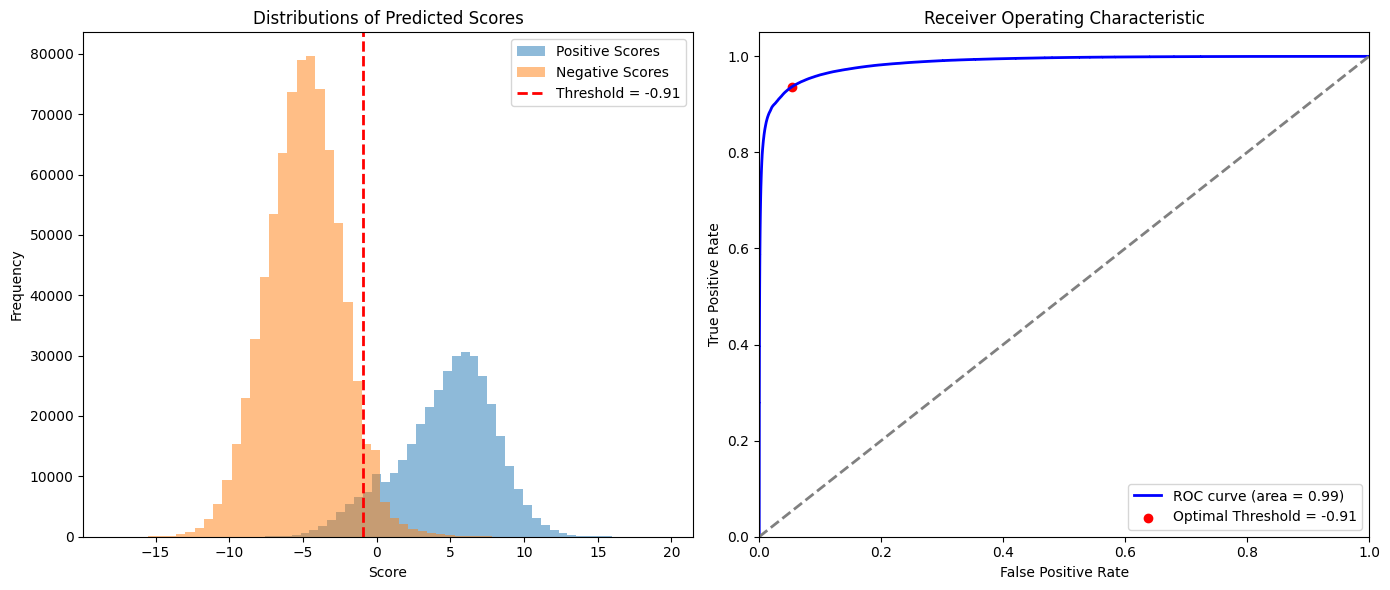

AUC: 0.9858647649704392
Optimal Threshold: -0.9091751575469971
Train Error [0.8050922751426697, 0.6533632278442383, 1.060038685798645, 0.603702187538147, 0.6534885764122009, 0.6978479623794556, 0.7068151235580444, 0.7073704600334167, 0.6987723112106323, 0.6877511143684387, 0.6654439568519592, 0.6272182464599609, 0.5712032318115234, 0.580079197883606, 0.5089694261550903, 0.5868713855743408, 0.6196591854095459, 0.6716750860214233, 0.433007150888443, 0.5042523145675659, 0.49432775378227234, 0.414985328912735, 0.4044210910797119, 0.4319939911365509, 0.4243084490299225, 0.3865969181060791, 0.3239096999168396, 0.3225780725479126, 0.3487990200519562, 0.30266764760017395, 0.2938968539237976, 0.2814318835735321, 0.2624031901359558, 0.27579739689826965, 0.24095425009727478, 0.27653223276138306, 0.28478091955184937, 0.2973194718360901, 0.22848057746887207, 0.2390640527009964, 0.2504367232322693, 0.26944416761398315, 0.19901569187641144, 0.20915384590625763, 0.21270692348480225, 0.1983871310949325

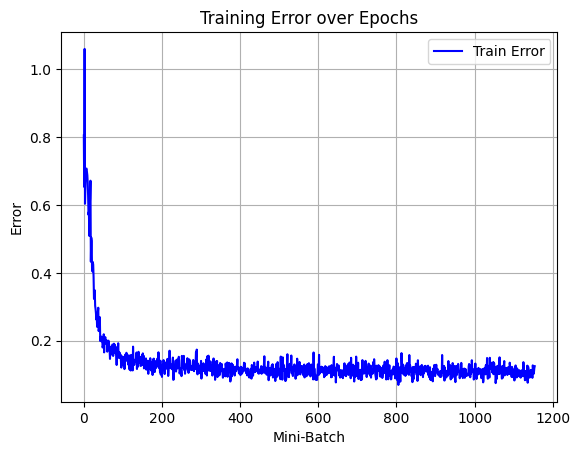

In [63]:

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
out_feats= 8


# # model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = ModelSAGESample(in_feats, h_feats, out_feats)
pred = MLPPredictor(8,1)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.05)

# ----------- 4. training -------------------------------- #
acc_val = []
acc_train = []

train_error = []
train_error_per_epoch = []
val_error_per_epoch = []
train_edges_id = []

# Inicializar listas para guardar logits y labels del entrenamiento
all_logits_train = []
all_labels_train = []

# Inicializar listas para guardar logits y labels de la validacion
all_logits_val = []
all_labels_val = []
# Almacenar la importancia de características por epoch
feature_importances = []
for epoch in range(5):
    model.train()
    val_loss_epoch=0
    num_batches = 0

    with tqdm.tqdm(train_dataloader) as tq:
        for step, (input_nodes, output_graph, mfgs) in enumerate(tq):
    
            mfgs = [graph for graph in mfgs]
            edge_ids = output_graph.edata[dgl.EID]
            inputs = mfgs[0].srcdata['feat']
            # Hacer que los inputs requieran gradiente
            inputs.requires_grad_(True)
            # Embeddings de nodos
            h = model(mfgs, inputs)
            logits =  pred(output_graph, h)
            
            
            train_edges_id.append(edge_ids)

            # Usar los IDs de los bordes para obtener las etiquetas reales
            labels_batch_output = gnn.dgl_graph.edata['Relationship'][edge_ids].float()

            all_logits_train.append(logits.detach().cpu().numpy())
            all_labels_train.append(labels_batch_output.cpu().numpy())
            # print("LOGITS",logits,logits.shape)
            # print("LABEL",mfgs[-1].edata['Relationship'].shape )

            # Calculo pérdida --------------------------------------------------------
            train_loss = F.binary_cross_entropy_with_logits(logits, labels_batch_output)
            train_error.append(train_loss.item())


            val_loss_epoch += train_loss.item()
            num_batches += 1
            
            # backward
            optimizer.zero_grad()
            # train_loss.backward()
            train_loss.backward()

                        # Capturar los gradientes con respecto a los inputs (características)
            grad = inputs.grad  # Este es el gradiente de la pérdida con respecto a los inputs
            feature_importance_batch = grad.abs().mean(dim=0).cpu().numpy()  # Promediar sobre los nodos y las dimensiones de características
            feature_importances.append(feature_importance_batch)
            optimizer.step()

    train_error_per_epoch.append(val_loss_epoch / num_batches)
        
    # Validación
    model.eval()
    val_loss_epoch = 0
    num_batches = 0
    with torch.no_grad():
        with tqdm.tqdm(test_dataloader) as tq:
            for step, (input_nodes, output_graph, mfgs) in enumerate(tq):
                mfgs = [graph for graph in mfgs]
                edge_ids = output_graph.edata[dgl.EID]
                inputs = mfgs[0].srcdata['feat']
                
                
                # Forward para validación
                h_val = model(mfgs, inputs)
                logits_val = pred(output_graph, h_val)

                # Guardar logits de validacion
                all_logits_val.append(logits_val.detach().cpu().numpy())

                # Obtener las etiuetas reales
                labels_batch_output_val = gnn.dgl_graph.edata['Relationship'][edge_ids].float()
                all_labels_val.append(labels_batch_output_val.cpu().numpy())
            
                # Calcular pérdida de validación
                val_loss_batch = F.binary_cross_entropy_with_logits(logits_val, labels_batch_output_val)
                val_loss_epoch += val_loss_batch.item()
                num_batches += 1

    # Almacenar el promedio de la pérdida de validación por epoch
    val_error_per_epoch.append(val_loss_epoch / num_batches)


    if epoch % 1 == 0:
        print('In epoch {}, train loss: {},'.format( epoch,train_loss))



# ----------- 5. Definir threashold -------------- 
# Concatenar todos los logits y etiquetas al final del entrenamiento
all_logits_train = np.concatenate(all_logits_train, axis=0)
all_labels_train = np.concatenate(all_labels_train, axis=0)
optimal_threshold = plot_roc_curve(all_labels_train, all_logits_train)
print(f"Optimal Threshold: {optimal_threshold}")
          

# ----------- 6. plot the loss and accuracy de training-------------- #
# FIXME: Ess asi por meintras para q no s ecaiga la funcion
print("Train Error",train_error)
# acc_train = train_error
# val_error = train_error
# acc_val = train_error
# model_complexity = [i for i in range(len(train_error))]


# Crear gráfico del error de entrenamiento
plt.figure()  # Crear una nueva figura
plt.plot([i for i in range(len(train_error))],train_error, label='Train Error', color='blue')  # Error de entrenamiento en azul
plt.xlabel('Mini-Batch')
plt.ylabel('Error')
plt.title('Training Error over Epochs')
plt.legend()
plt.grid(True)
plt.show()  # Mostrar el gráfico de error de entrenamiento


# ----------- 6. Visualización de la Importancia de Características -------------- #
# Convertir la lista de importancias en un array para análisis
# feature_importances = np.array(feature_importances)

# Calcular la importancia promedio a lo largo de todos los batches y epochs
# avg_feature_importance = feature_importances.mean(axis=0)

# plt.figure()
# plt.bar(range(len(avg_feature_importance)), avg_feature_importance)
# plt.xlabel('Feature Index')
# plt.ylabel('Average Importance')
# plt.title('Average Feature Importance over Training')
# plt.show()


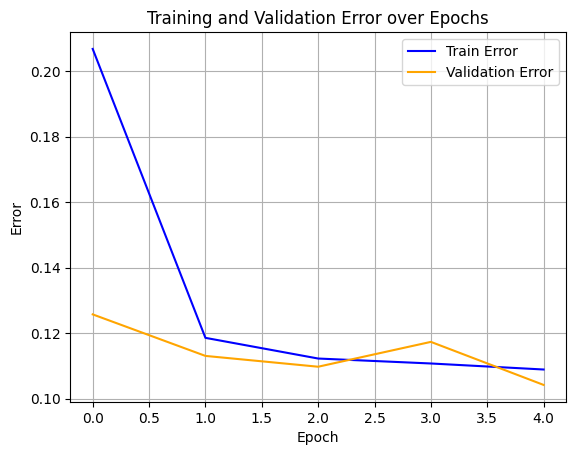

In [64]:
# Crear gráfico combinado de error de entrenamiento y validación
plt.figure()  # Crear una nueva figura
plt.plot(train_error_per_epoch, label='Train Error', color='blue')  # Error de entrenamiento en azul
plt.plot(val_error, label='Validation Error', color='orange')  # Error de validación en naranja
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Training and Validation Error over Epochs')
plt.legend()
plt.grid(True)
plt.show()  # Mostrar el gráfico combinado

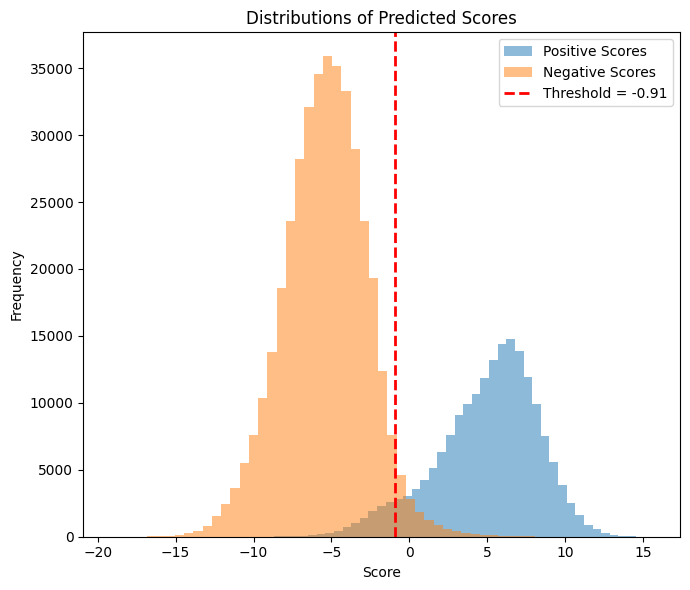

AUC: 0.9882687977128597


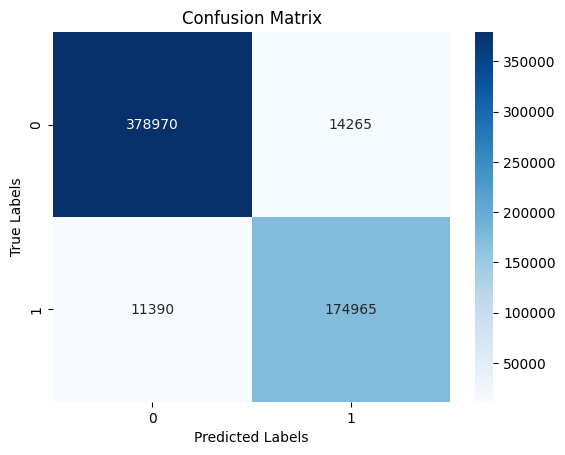

Classification Report:

              precision    recall  f1-score   support

         0.0     0.9708    0.9637    0.9673    393235
         1.0     0.9246    0.9389    0.9317    186355

    accuracy                         0.9557    579590
   macro avg     0.9477    0.9513    0.9495    579590
weighted avg     0.9560    0.9557    0.9558    579590



In [67]:
all_logits_val = np.concatenate(all_logits_val, axis=0)
all_labels_val = np.concatenate(all_labels_val, axis=0)

plot_roc_curve(all_labels_val, all_logits_val, optimal_threshold)
calculate_metrics(all_logits_val,all_labels_val , optimal_threshold)


In [8]:
# Concatenar todos los logits y etiquetas de validación
all_logits_val = np.concatenate(all_logits_val, axis=0)
all_labels_val = np.concatenate(all_labels_val, axis=0)

# # Usar sigmoid para convertir los logits en probabilidades
# probs_val = torch.sigmoid(torch.tensor(val_logits))

# Definir el umbral óptimo o usar un valor por defecto (0.5)
threshold = optimal_threshold
all_logits_val = (all_logits_val > threshold).astype(float)  #.numpy()
# print(preds_val)
print(all_logits_val)
print(all_labels_val)
# Generar el classification report para la validación
report_val = classification_report(all_logits_val, all_logits_val, target_names=['Class 0', 'Class 1'])

# Mostrar el classification report de validación
print(report_val)
            

[0. 0. 1. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00    128947
     Class 1       1.00      1.00      1.00     55237

    accuracy                           1.00    184184
   macro avg       1.00      1.00      1.00    184184
weighted avg       1.00      1.00      1.00    184184



In [20]:
predicted_scores = 
true_values = 
threshold = optimal_threshold
calculate_metrics(predicted_scores,true_values , threshold)

TypeError: calculate_metrics() missing 2 required positional arguments: 'predicted_scores' and 'true_values'